## Setup

In [ ]:
# !git clone https://github.com/rrakotom/ActMax-Optimizer-Dev.git
# !pip install cma==3.0.3
# !pip install nevergrad==0.4.2.post5
# %cd ActMax-Optimizer-Dev
# %mkdir tmp

In [ ]:
# !git pull

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

In [2]:
assert torch.cuda.is_available()

## Activation Optimization for Transformers

In [3]:
# Import the experiment class
from transformers.tf_exp import TransformerEvolution

In [4]:
tmpsavedir = "./tmp"
explabel, model_unit = "vit_b_16_exp", ("vit_b_16", ".heads.Linearhead", 0)

In [5]:
exp = TransformerEvolution(model_unit, explabel=explabel, savedir=tmpsavedir)

Space dimension: 4096, Population size: 40, Select size:20, Optimization Parameters:
Initial sigma: 3.000
cc=0.001, cs=0.050, c1=0.000 damps=1.050


In [6]:
exp.run()

synth img scores: mean -0.758 +- std 0.000
step 0  time: total 0.07s | GAN visualize 0.01s   Transformers score 0.02s   optimizer step 0.05s
sigma: 2.90
synth img scores: mean -0.611 +- std 0.512
step 1  time: total 0.68s | GAN visualize 0.08s   Transformers score 0.55s   optimizer step 0.05s
sigma: 2.83
synth img scores: mean -0.291 +- std 0.759
step 2  time: total 0.64s | GAN visualize 0.06s   Transformers score 0.55s   optimizer step 0.03s
sigma: 2.76
synth img scores: mean -0.295 +- std 0.636
step 3  time: total 0.64s | GAN visualize 0.06s   Transformers score 0.53s   optimizer step 0.05s
sigma: 2.71
synth img scores: mean -0.043 +- std 0.680
step 4  time: total 0.64s | GAN visualize 0.06s   Transformers score 0.54s   optimizer step 0.04s
sigma: 2.66
synth img scores: mean -0.133 +- std 0.532
step 5  time: total 0.64s | GAN visualize 0.06s   Transformers score 0.54s   optimizer step 0.04s
sigma: 2.62
synth img scores: mean 0.249 +- std 0.478
step 6  time: total 0.66s | GAN visualiz

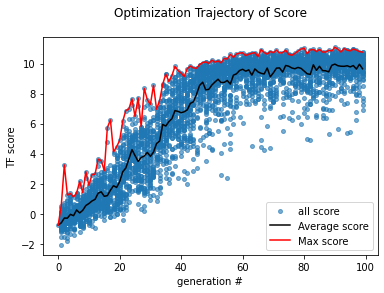

In [7]:
fig = exp.visualize_trajectory(type="TF")

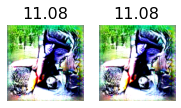

In [9]:
syn = exp.visualize_best(True)

## Animate the evolution

In [12]:
from core.GAN_utils import upconvGAN
G = upconvGAN("fc6")
G.cuda().eval();
avg_codes = [exp.codes_all[exp.generations == geni, :].mean(axis=0) for geni in range(100)]
avg_codes = np.stack(avg_codes)
avg_activ = np.array([exp.scores_all[exp.generations == geni].mean(axis=0) for geni in range(100)])

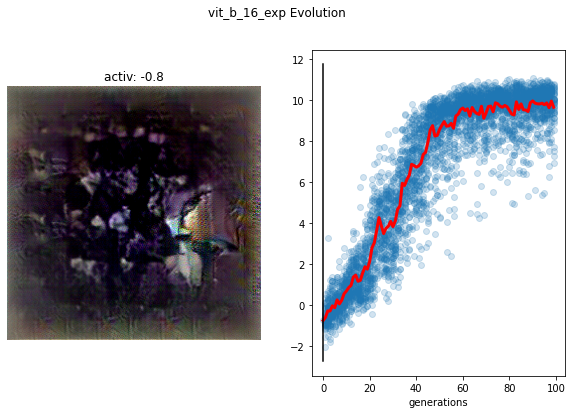

In [14]:
imgs_per_gen = G.visualize_batch_np(avg_codes)
imgs_per_gen_np = imgs_per_gen.permute([0,2,3,1]).numpy()

fig, axs = plt.subplots(1, 2, figsize=[10,6])
tit = axs[0].set_title(f"activ: {avg_activ[0]:.1f}")
ims = axs[0].imshow(imgs_per_gen_np[0])
axs[0].axis("Off")
axs[1].scatter(exp.generations, exp.scores_all, alpha=0.2)
axs[1].plot(range(100), avg_activ, c="red", lw=3)
axs[1].set_xlabel("generations")
fig.suptitle(f"{explabel} Evolution")
YLIM = axs[1].get_ylim()
lin1, = axs[1].plot([0,0], YLIM, color="k")
def drawframe_score(n):
    ims.set_data(imgs_per_gen_np[n])
    tit.set_text(f"activ: {avg_activ[n]:.1f}")
    lin1.set_data([n, n], YLIM)
    return (ims, tit, lin1) 

In [16]:
anim = animation.FuncAnimation(fig, drawframe_score, frames=100, interval=100, blit=False, repeat=True)
anim.save('./tmp/basic_animation.mp4', fps=30)

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 720x432 -pix_fmt rgba -r 30 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y ./tmp/basic_animation.mp4
